In [1]:
import sys, os
sys.path.append( os.path.join( '..', 'src' ) ) # set path to project src/

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [3]:
from utils import kaggle_io, kaggle_reader
from analysis import moving_window

In [4]:
import sklearn.externals.joblib
import scipy.misc
import importlib

In [5]:
# first define home path as kaggle_nuclei/, i.e., one level up from kaggle_nuclei/notebooks
homepath = os.path.join('..')
# define path for the kaggle csv file
f = os.path.join(homepath,'data','raw','stage1_train_labels.csv')
# define path for the unzipped training image folder
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')

In [6]:
# load csv file and decode the nuclei pixel locations for use later
decodedlabels = kaggle_reader.read_kaggle_csv(f)
# load all the images into gray scale
imgDF = kaggle_reader.load_all_raw_images(impath, mode='RGB')

In [7]:
importlib.reload(moving_window)

<module 'analysis.moving_window' from '..\\src\\analysis\\moving_window.py'>

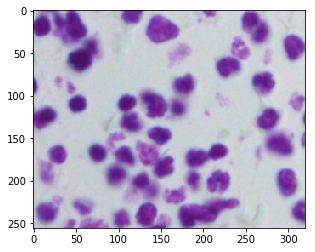

In [127]:
test_image = scipy.misc.imread('../data/small_split/test_image2.png', mode='RGB')
plt.imshow(test_image)

In [9]:
image_array = scipy.misc.imread('../data/raw/stage1_train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png')

In [10]:
test_image = image_array

In [11]:
classifier = sklearn.externals.joblib.load('../models/neural_network_adam_200_100_nobuffer_gray_trimmed.pkl')

Preprocess image
Extracting sub images 0.023561477661132812
Extracting features 0.6629018783569336
Running prediction 0.5244755744934082
eliminating overlap 1.176170825958252


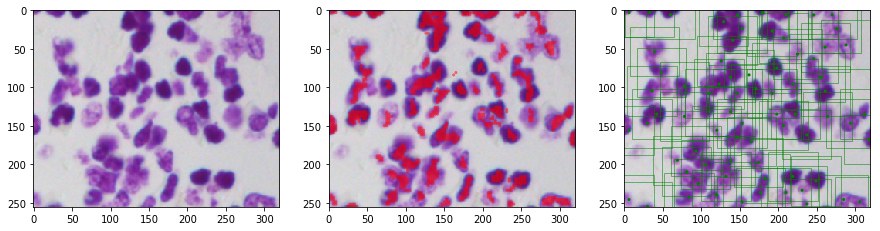

In [67]:
nn_gr_posbox, nn_centers = moving_window.run_moving_window(classifier, test_image, 'pixelval', 
                                {}, {'rgb2gray': None, 'trim': [1,99]}, [64, 64], [3, 3], 0.5)

Preprocess image
Extracting sub images 0.01304006576538086
Extracting features 

C:\Users\YOUY\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


0.655482292175293
Running prediction 0.48944735527038574
eliminating overlap 2.1806821823120117


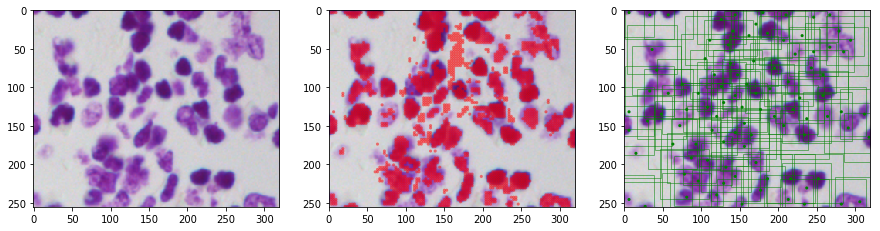

In [13]:
nnclass2 = sklearn.externals.joblib.load('../models/neural_network_adam_200_100_center_3px_roi.pkl')
nnpos_box = moving_window.run_moving_window(nnclass2, test_image, 'pixelval', 
                                          {},
                                          {'rgb2gray': None, 'trim': [1,99], 'norm': 'clahe'}, [64,64],[3,3],0.5)

In [14]:
gkclass = sklearn.externals.joblib.load('../models/gkhp_svm_auto_tuned_center3px_window10_clahe_p10data.pkl')

Preprocess image
Extracting sub images 0.026052474975585938
Extracting features 

C:\Users\YOUY\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


4.20371675491333
Running prediction 6.386098384857178
eliminating overlap 2.9693377017974854


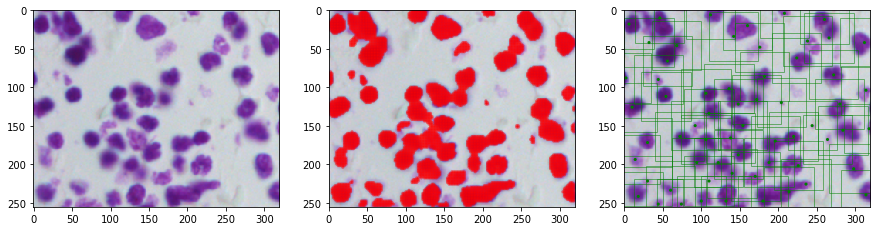

In [128]:
pos_box, centers = moving_window.run_moving_window(gkclass, test_image, 'gkhp', 
                                {'sigmas': [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 200 ] },
                               {'rgb2gray': None, 'trim': [1,99], 'norm': 'clahe'}, [64,64],[2,2],0.4)

Preprocess image
Extracting sub images 

C:\Users\YOUY\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


0.27605295181274414
Extracting features 0.7627878189086914
Running prediction 0.12634062767028809
eliminating overlap 0.5448434352874756


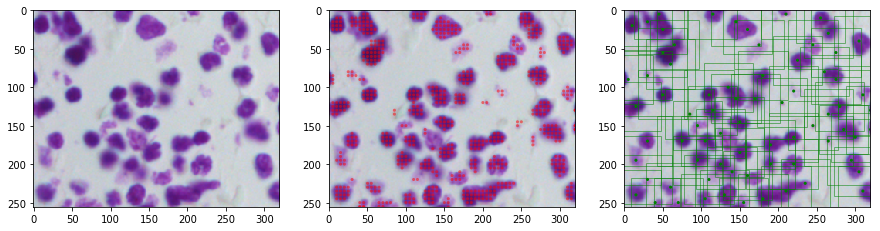

In [129]:
gkclass2 = sklearn.externals.joblib.load('../models/gkhp_svm_auto_tuned_neg8_clahe.pkl')
pos_box2, gkcenters2 = moving_window.run_moving_window(gkclass2, test_image, 'gkhp', 
                                          {'sigmas': [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 200 ] },
                                          {'rgb2gray': None, 'trim': [1,99], 'norm': 'clahe'}, [64,64],[5,5],0.5)

In [27]:
pos_box.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [14]:
from preprocess import image_processing

In [25]:
def mask_from_positive_box(positive_boxes, image_sizes):
    half_subimage_size = [31, 31]
    mask = np.zeros(image_sizes)
    for anchor in positive_boxes.SubImageAnchor:
        mask[anchor[0]+half_subimage_size[0], anchor[1]+half_subimage_size[1]] = 1
    return mask

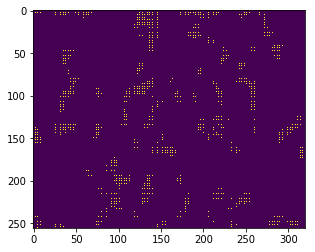

In [52]:
center_mask = mask_from_positive_box(nn_gr_posbox, test_image.shape[:2])
plt.imshow(mask)

In [53]:
import skimage.morphology

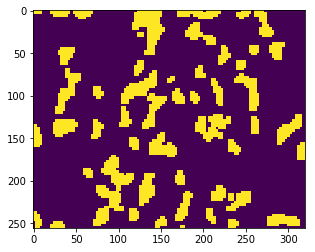

In [56]:
center_mask = skimage.morphology.binary_dilation(center_mask, skimage.morphology.square(4))
plt.imshow(center_mask)

In [57]:
import scipy.ndimage

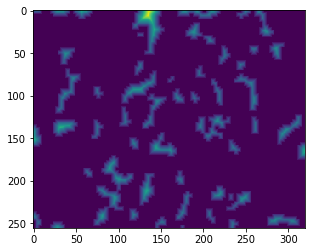

In [59]:
center_distance = scipy.ndimage.distance_transform_edt(center_mask)
plt.imshow(center_distance)

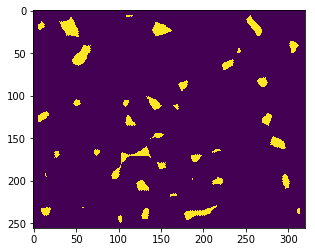

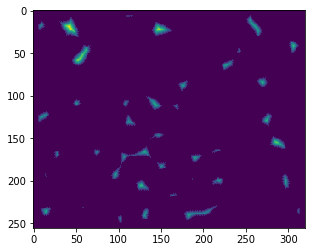

In [144]:
mask = mask_from_positive_box(pos_box, test_image.shape[:2])
erosion_mask = skimage.morphology.closing(mask, skimage.morphology.disk(3))
erosion_mask = skimage.morphology.binary_erosion(erosion_mask, skimage.morphology.disk(6))
plt.imshow(erosion_mask)
plt.show()
center_distance = scipy.ndimage.distance_transform_edt(erosion_mask)
plt.imshow(center_distance)

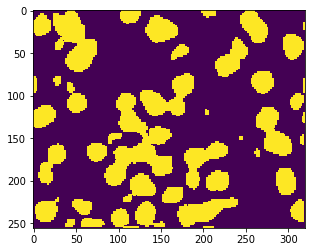

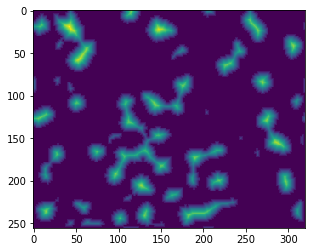

In [145]:
mask = mask_from_positive_box(pos_box, test_image.shape[:2])
mask = skimage.morphology.binary_dilation(mask, skimage.morphology.square(3))
plt.imshow(mask)
plt.show()
distance = scipy.ndimage.distance_transform_edt(mask)
plt.imshow(distance)

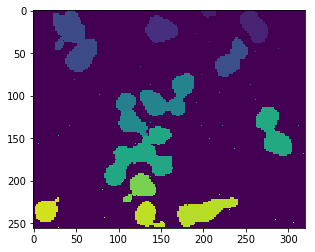

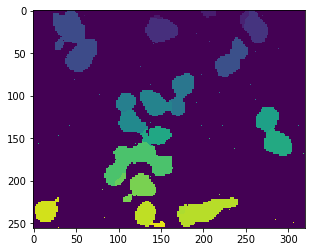

In [146]:
from analysis import image_segmentation
nn_center_points = image_segmentation.boxes_to_centers(nn_centers, test_image.shape)
lbl = skimage.measure.label(nn_center_points)
ids = skimage.morphology.watershed(-distance, lbl, mask=mask)
plt.imshow(ids)
plt.show()
ids2 = skimage.morphology.watershed(-center_distance, lbl, mask=mask)
plt.imshow(ids2)

In [74]:
    image_root = os.path.join('..', 'data', 'split', 'train')
    imdirs = [d for d in os.listdir(image_root)
              if os.path.isdir(os.path.join(image_root, d))]
    test_image_root = np.random.choice(imdirs)
    # image_array = scipy.misc.imread('../data/raw/stage1_train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png')
    image_array = scipy.misc.imread(os.path.join(image_root, test_image_root, 'images', test_image_root+'.png'))
    expected_masks_directory = os.path.join(image_root, test_image_root, 'masks')

In [75]:
expected_masks_directory

'..\\data\\split\\train\\f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d\\masks'

In [29]:
def extract_total_mask(imgid, decodedlabels, image_shape):
    """
    collects the pixel values (in gray scale) of nucleis and background (non-nuclei regions) in a single gray scale
    image
    :param imgid: the ImageId to work on
    :param decodedlabels: decoded pixel labels read from Kaggle csv and decoded (see utils/kaggle_reader.py)
    :param imgDF: dataframe of all the images, loaded by load_all_images in utils/kaggle_reader.py
    :return: two 1D arrays: first an array of pixel values for the nucleis, second an array of pixel values for the
            background
    """

    # find all the nucleis associated with the given image
    nucleis = decodedlabels[decodedlabels.ImageId == imgid].DecodedPixels.values
    # initialize the list for pixel indices that are part of a nuclei
    all_nuclei_index = []
    for nuclei in nucleis:
        # add pixel indices from each nuclei to the common list
        all_nuclei_index.extend(nuclei)
    # generate a mask the same size of the raveled image vector where True = background and False = nuclei
    mask = np.zeros(np.prod(image_shape),)
    mask[all_nuclei_index] = 1
    return mask.reshape(image_shape, order='F')

In [30]:
from utils import kaggle_io

In [31]:
# first define home path as kaggle_nuclei/, i.e., one level up from kaggle_nuclei/notebooks
homepath = os.path.join('..')
# define path for the kaggle csv file
f = os.path.join(homepath,'data','raw','stage1_train_labels.csv')
# define path for the unzipped training image folder
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')

In [32]:
decodedlabels = kaggle_reader.read_kaggle_csv(f)

In [33]:
true_mask = extract_total_mask('0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3',
                              decodedlabels, test_image.shape[:2])

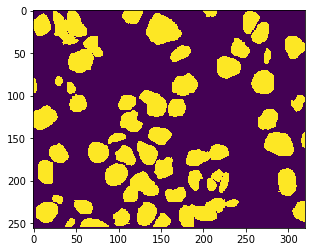

In [34]:
plt.imshow(true_mask)

In [214]:
np.sum( (true_mask == 1) & (processed_mask==1))/np.sum( (true_mask == 1) | (processed_mask==1))

0.63618066178246513

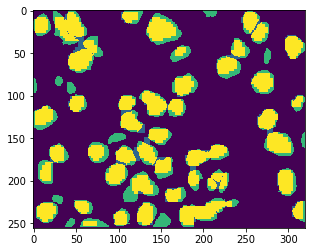

In [215]:
plt.imshow(true_mask*2+processed_mask)

In [37]:
def extract_windowed_subimages_from_image(image_array, window_sizes, step_sizes):
    image_sizes = image_array.shape
    ndim = len(image_sizes)
    if ndim > 2:
        padded_image = np.zeros((image_sizes[0]+window_sizes[0],
                                image_sizes[1]+window_sizes[1],
                                image_sizes[2]))
        for channel in range(image_sizes[2]):
            padded_image[:,:,channel] = skimage.util.pad(image_array[:,:,channel], 
                                                     (int(window_sizes[0]/2), int(window_sizes[1]/2)),
                                                    'constant',
                                                    constant_values=np.median(image_array[:,:,channel]))
    else:
        padded_image = np.zeros((image_sizes[0]+window_sizes[0],
                                image_sizes[1]+window_sizes[1] ))
        padded_image = skimage.util.pad(image_array, 
                                        (int(window_sizes[0]/2), int(window_sizes[1]/2)),
                                        'constant',
                                        constant_values=np.median(image_array))
    plt.imshow(padded_image)
    # populate the window starting points
    window_col_start = list(range(0, image_sizes[1] + 1 - window_sizes[1], step_sizes[0]))
    window_row_start = list(range(0, image_sizes[0] + 1 - window_sizes[0], step_sizes[1]))
    r = image_sizes[1] % step_sizes[0]
    if r > 0:
        window_col_start.append(image_sizes[1] - window_sizes[1])
        window_row_start.append(image_sizes[0] - window_sizes[0])

    sub_images = []
    sub_images_anchors = []
    for c in window_col_start:
        for r in window_row_start:
            # each window starts on the left upper conner at (r, c) and has a height of window_sizes[0]
            # and width of window_sizes[1]
            if ndim > 2:
                sub_images.append(image_array[r:r + window_sizes[0], c:c + window_sizes[1], :])
            else:
                sub_images.append(image_array[r:r + window_sizes[0], c:c + window_sizes[1]])
            sub_images_anchors.append([r, c])
    return pd.DataFrame(list(zip(sub_images, sub_images_anchors)), columns=['ImageMat', 'SubImageAnchor'])

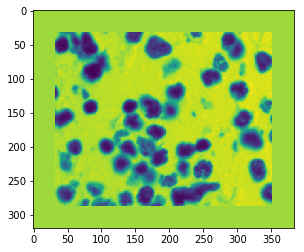

In [38]:
plt.imshow(skimage.util.pad(test_image[:,:,1], (32, 32), 'constant', 
                            constant_values=np.median(test_image[:,:,1])))

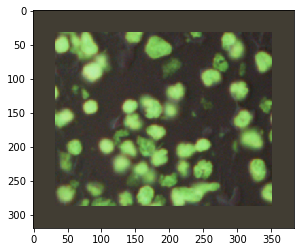

In [39]:
sub_images = extract_windowed_subimages_from_image(test_image, [64, 64], [5, 5])

In [40]:
np.save('predicted_mask.npy', processed_mask)

In [41]:
pos_box.iloc[0]['SubImageAnchor']

[-17, -32]

In [42]:
np.save('true_mask.npy', true_mask)

In [43]:
overlap = pos_box.iloc[[1, 2]].prediction - 0.1

In [44]:
np.where(overlap>0.5)[0].tolist()

[0, 1]

In [45]:
a = [1, 2, 3]

In [46]:
np.delete(a, np.where(overlap>0.55))

array([3])

In [47]:
np.array(pos_box.ImageMat.apply(np.shape).tolist())[:,2]

IndexError: index 2 is out of bounds for axis 1 with size 2

In [99]:
mask = scipy.misc.imread('../data/split/train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/masks/1811379154b848c048f574745ed49e5dad19125e1a8c31b92ed2ee643ba04011.png', mode='L')

In [100]:
mask[mask!=0]=1

In [103]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [142]:
from analysis import hog_classifier

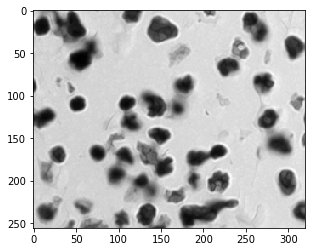

In [150]:
enhanced_image = image_processing.process_image(test_image, {'rgb2gray': None})
gradx, grady = hog_classifier.derivative_mask_1d_centered(enhanced_image)
orientation, strength = hog_classifier.find_grad_orientation_strength(gradx, grady)
enchaned_edge_image = enhanced_image*0.5 + strength*0.5
plt.imshow(enchaned_edge_image, cmap='gray')

In [1]:
import skimage.filters

In [105]:
data = pd.read_pickle('../data/roi/test_dataframe_center_3px.pkl')

In [16]:
data.index.values

array([   0,    1,    2, ..., 3093, 3094, 3095], dtype=int64)

In [106]:
def roi_from_processed_images(image_df, image_col_name, image_id_col_name, roi_df, image_options):
    output_matrix = []
    output_index = []
    output = roi_df.copy()
    output = output.assign(row1=np.maximum(0, roi_df.index_row-np.floor(roi_df.extract_height/2))+1)
    output = output.assign(row2=np.maximum(0, roi_df.extract_height+output.row1))
    output = output.assign(col1=np.maximum(0, roi_df.index_col-np.floor(roi_df.extract_width/2))+1)
    output = output.assign(col2=np.maximum(0, roi_df.extract_width+output.col1))
    for i in range(len(image_df)):
        image_id = image_df[image_id_col_name][i]
        processed_image = image_processing.process_image(image_df[image_col_name][i], image_options)
        rois = output[output.parent_image_id == image_id]
        for index, roi in rois.iterrows():
            output.set_value(index, 'image_matrix', 
                             processed_image[int(roi.row1):int(roi.row2),int(roi.col1):int(roi.col2)])
            output_matrix.append(processed_image[int(roi.row1):int(roi.row2),int(roi.col1):int(roi.col2)])
            output_index.append(index)

    processed_roi = pd.DataFrame(output_matrix, index=output_index, columns=['processed_roi'])
    output = output.join(processed_roi)

    return output
            

In [107]:
center3px_clahe=roi_from_processed_images(imgDF, 'ImageMat', 'ImageId', data, 
                                    {'rgb2gray': None, 'trim': [1, 99], 'norm': 'clahe'})

C:\Users\YOUY\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [61]:
neg32_clahe.to_pickle('../data/roi/neg32_clahe/train_dataframe.pkl')

In [108]:
data.iloc[25][['index_col', 'index_row', 'extract_width', 
               'extract_height', 'row1', 'row2', 'col1', 'col2']]

index_col         134
index_row         223
extract_width      64
extract_height     64
row1              NaN
row2              NaN
col1              NaN
col2              NaN
Name: 25, dtype: object

In [109]:
neg32_clahe.iloc[25][['index_col', 'index_row', 'extract_width', 
               'extract_height', 'row1', 'row2', 'col1', 'col2']]

index_col         185
index_row         175
extract_width      64
extract_height     64
row1              153
row2              217
col1              143
col2              207
Name: 25, dtype: object

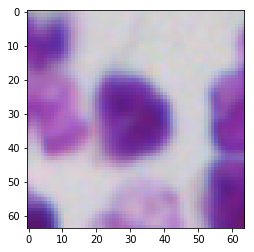

In [139]:
idx = 100
plt.imshow(data.image_matrix[idx], cmap='gray')

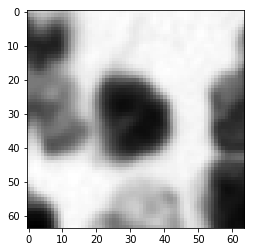

In [140]:
plt.imshow(image_processing.process_image(data.image_matrix[idx], 
                                          {'rgb2gray': None}), cmap='gray')

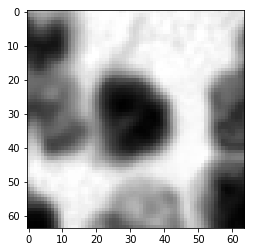

In [141]:
plt.imshow(center3px_clahe.image_matrix[idx], cmap='gray')

In [ ]:
fi